In [1]:
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pickle
import cv2
import os
import numpy as np
import time

from maze_utils import *
from behav_utils import *
from ms_utils import *

mice_status = pd.read_excel("mice_maze_metadataAng.xlsx", sheet_name=0)
mice_names = mice_status["name"].values
data = pd.read_excel("mice_maze_metadataAng.xlsx", sheet_name=2)
video_name = "behavCam1.avi" # first video
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('img'):
    os.makedirs('img')


In [2]:
mice_names = mice_status["name"]
# maze_type_mice = set(data[data.name == mice_names[0]]["maze_type"])
maze_type_mice = {1}
training_day_set = set(data[(data.name == mice_names[0]) & (data.maze_type == 1)]["training_day"])
training_day_set

{1, 2, 3, 4, 5, 6, 7, 8}

M10033maze1Day1
144    Z:/miniscope_recording/maze/4_18_2020/10033H12...
Name: recording_folder_local, dtype: object
Adding point #0 with position(21,20)
Adding point #1 with position(19,342)
Adding point #2 with position(345,349)
Adding point #3 with position(348,18)
Polygon = [(21, 20), (19, 342), (345, 349), (348, 18)]
The maze is bidirectional, Ye!
Node 1 is Decision point
Node 2 is Leaf node
Node 13 is Decision point
Node 6 is Decision point
Node 8 is Leaf node
Node 17 is Decision point
Node 28 is Leaf node
Node 30 is Decision point
Node 24 is Decision point
Node 84 is Decision point
Node 94 is Decision point
Node 55 is Decision point
Node 43 is Leaf node
Node 54 is Decision point
Node 53 is Leaf node
Node 51 is Decision point
Node 39 is Decision point
Node 40 is Leaf node
Node 97 is Decision point
Node 86 is Leaf node
Node 109 is Decision point
Node 129 is Decision point
Node 139 is Leaf node
Node 142 is Decision point
Node 130 is Decision point
Node 120 is Leaf node
Node 144 is 

<ipython-input-7-f8cf48530668>:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Shortest path =  1 13 14
Shortest path =  59 58 57 56 68
Shortest path =  23 24 36
Shortest path =  36 24 23
Shortest path =  110 109 121 133 134
Shortest path =  134 133 121
Shortest path =  73 61 49 37 38 39 51 50
Shortest path =  110 122 123
Shortest path =  98 97 85
Shortest path =  104 103 91 90 78 79 67 55 54 66 65 64 63 75 74 62 50 51 39 38 37 49 61 73 85 97 109 110 122 123 111 112 100 99 87 88 76 77 89 101 102 114 113 125 124 136 137 138 126 127 115 116
Shortest path =  116 115 127 126 138 137 136 124 125 113 114 102 101 89 77 76 88 87 99 100 112 111 123 122 110 109 97 85 73 61 49 37 38 39 51 50 62 74 75 63 64 65 66 54 55 67 79 78 90 91 103 104
Shortest path =  104 103 91 90 78 79 67 55 54 66 65 64 63 75 74 62 50 51 39 38 37 49 61 73 85 97 109 110 122 123 111 112 100 99 87 88 76 77 89 101 102 114 113 125 124 136 137 138 126 127 115 116
Shortest path =  116 115 127 126 138 137 136 124 125 113 114 102 101 89 77 76 88 87 99 100 112 111 123 122 110 109 97 85 73 61 49 37 38 39 51 50

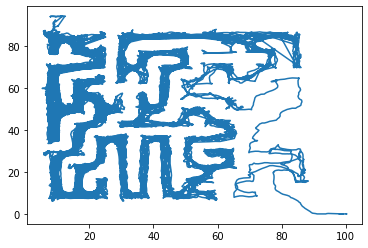

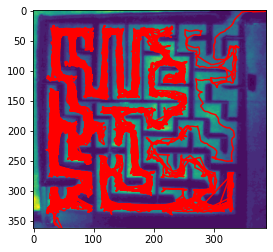

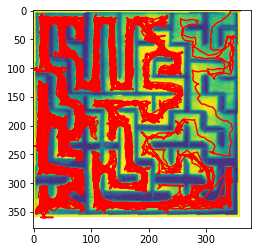

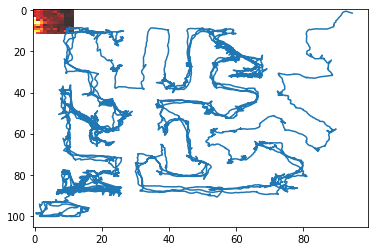

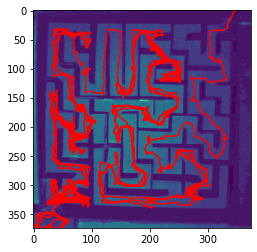

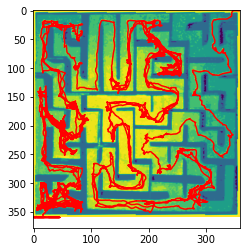

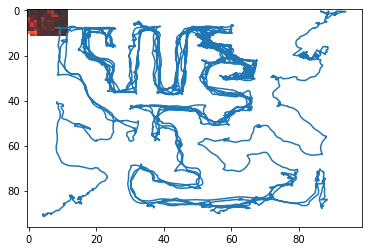

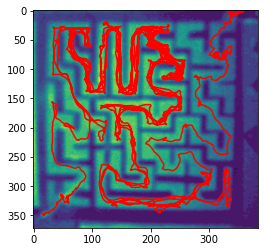

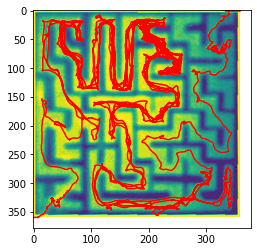

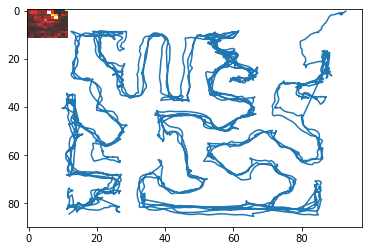

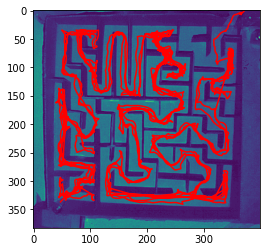

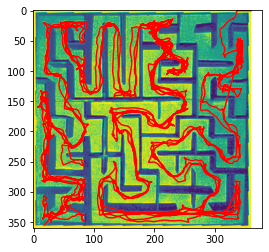

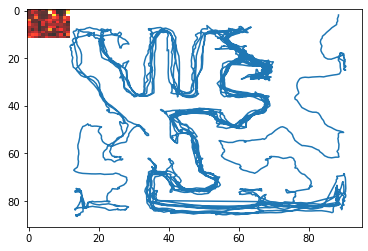

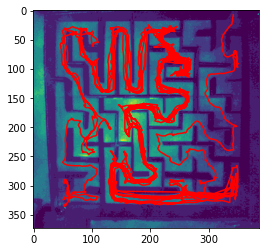

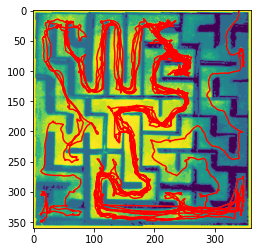

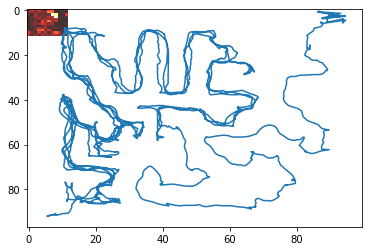

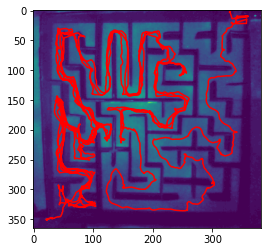

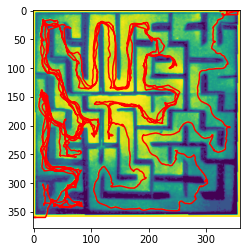

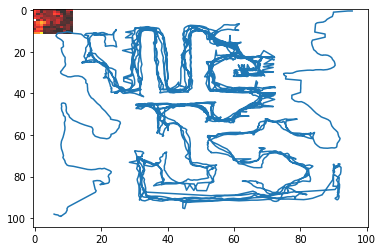

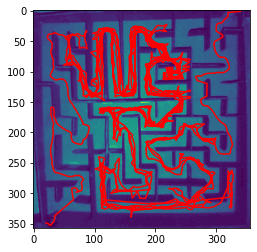

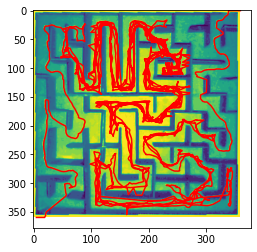

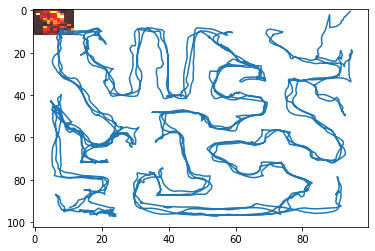

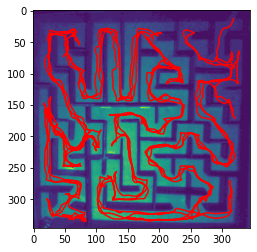

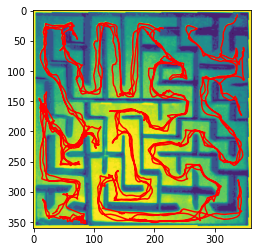

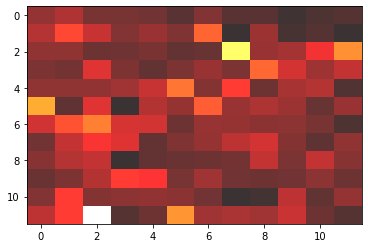

In [7]:
# Loop over mice_name, maze_type and training_day
mice_names = [10033]
for mice_name in mice_names:
    # maze_type_set = set(data[data.name == mice_name]["maze_type"])
    maze_type_set = {1}

    for maze_type in maze_type_set:
        training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])
        for i_day in training_day_set:
            current_day = i_day
            current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
            print(current_sign)
            folder =  data[(data.name == mice_name) & (data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_local"]
            print(folder)
            matfile = folder.values[0] + "/" + "behav_new.mat"
            videofile = folder.values[0] + "/" + video_name
            behav_mat = loadmat(matfile);

            ### define useful variables: time, positions, etc.
            # position number 13
            behav_positions = behav_mat['behav'][0][0][14]
            behav_time = behav_mat['behav'][0][0][9]
            # delete first 50 frames (~1.7s), when the mouse is not in the maze
            delete_start = 50
            behav_positions = np.delete(behav_positions, range(0,delete_start),0)
            behav_time = np.delete(behav_time, range(0,delete_start))
            # delete NAN values
            nan_mask = np.isnan(behav_positions).any(axis=1)
            behav_time_original = behav_time
            behav_positions = behav_positions[~nan_mask, ]
            behav_time = behav_time[~nan_mask]
                        
            behav_roi = behav_mat['behav'][0][0][12][0]
            roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )
            # Deleting Outliers: creating a copy, deleting outliers
            behav_len = behav_positions.shape[0]
            nan_seq_len = 0
            delta = 0
            max_speed = 50 # 50 cm/s
            behav_positions_tmp = behav_positions
            good_ind_diff = 1
            for i in range(1,behav_len):
                delta = np.sqrt(np.sum(np.square(behav_positions[i,] - behav_positions[i-good_ind_diff,])))
                time_diff = behav_time[i] - behav_time[i-good_ind_diff]
                speed_tmp = delta/time_diff*1000
                if speed_tmp > max_speed:
                    # print(i, behav_positions[i,],behav_positions[i-1,], speed_tmp, time_diff, delta)
                    behav_positions_tmp[i,] = np.nan
                    good_ind_diff += 1
                else:
                    good_ind_diff = 1
            nan_mask2 = np.isnan(behav_positions_tmp).any(axis=1)
            behav_positions = behav_positions_tmp[~nan_mask2, ]
            behav_time = behav_time[~nan_mask2]
            plt.figure()
            plt.plot(behav_positions[:,0], behav_positions[:,1])

            # get start, end time
            start_time = behav_time[0]
            end_time = behav_time[-1]
            total_time = end_time- start_time
            stay_time = np.append(np.ediff1d(behav_time),33)
            # get end index
            end_index = np.where(behav_time_original == end_time)[0][0]
            behav_time_original = behav_time_original[0:(end_index+1)]
            # define behavior x, y, roi
            behav_x = behav_positions[:,0]
            behav_y = behav_positions[:,1]
            track_length = behav_mat['behav'][0][0][-1][0]

            #### perspective transformation
            plt.figure()
            # get mean frame
            mean_frame = get_meanframe(videofile)
            # plot mean frame
            ori_positions = behav_positions * behav_roi[2]/track_length
            plt.plot(ori_positions[:,0],ori_positions[:,1], color = "red")
            plt.imshow(mean_frame[roi[2]:roi[3], roi[0]:roi[1]].astype(int))
            equ_meanframe = cv2.equalizeHist(np.uint8(mean_frame[roi[2]:roi[3], roi[0]:roi[1]]))
            ori_positions = behav_positions * behav_roi[2]/track_length
            FINAL_LINE_COLOR = (255, 100, 0)
            WORKING_LINE_COLOR = (127, 127, 127)
            polydraw = PolygonDrawer("Original: select 4 maze corners", equ_meanframe, ori_positions)
            warped_image,warped_positions, M  = polydraw.run()
            cv2.imwrite("img/"+current_sign+"_polygon.png", warped_image)
            print("Polygon = %s" % polydraw.points)
            with open('data/' + current_sign + "PerspTrans.pkl", 'wb') as f:
                pickle.dump(M, f)
            cv2.destroyWindow("Original: select 4 maze corners")
            cv2.destroyWindow("Processed Maze")
            # plot results
            maxWidth = 360
            maxHeight = 360
            neg_mask = (warped_positions<0).any(axis =1)
            processed_pos = warped_positions
            processed_pos[warped_positions <0] = 0
            processed_pos[warped_positions[:,0] >maxWidth, 0] = maxWidth
            processed_pos[warped_positions[:,1] >maxHeight, 1] = maxHeight
            plt.figure()
            plt.imshow(warped_image)
            plt.plot(processed_pos[:,0], processed_pos[:,1], color = "red")
            plt.savefig('img/'+current_sign+'warped_image.png', dpi=100)

            #### calculate occupation time in each bin
            _nbins = 12
            _coords_range = [[0,maxWidth +0.01],[0, maxHeight+0.01]]
            activation = stay_time
            occu_time, xbin_edges, ybin_edges, bin_numbers = calculate_ratemap(processed_pos, activation, statistic = "sum", _nbins = _nbins, _coords_range=_coords_range)
            # plot
            plt.figure()
            cm="hot"
            plot_ratemap(np.transpose(occu_time), cmap=cm, alpha = 0.8)
            plt.savefig('img/'+current_sign+'occutime_bin.png', dpi=100)


            #### Incorporate maze structure to behavior trajectory: interpolation, etc..
            # transform bin number, making upper right bin (1, 1)
            transformed_bin_number = transform_bin(bin_numbers)
            nx = 12
            ny = 12

            graph = maze1_graph if maze_type==1 else maze2_graph
            total_bin = nx*ny
            start_node = 1
            end_node = 144
            test_maze = Maze(nx, ny, graph)
            new_maze = test_maze.make_maze()
            shortest_path = BFS_SP(graph, start_node, end_node) # shortest path
            cell_dists = test_maze.cell_dists # cell distance to goal
            behav_nodes = test_maze.loc_to_idx(transformed_bin_number[0,:]-1, transformed_bin_number[1,:]-1)
            ## interpolation
            behav_nodes_interpolated = interpolate_pos_maze(behav_time, behav_nodes, behav_time_original, graph, test_maze)
            ## behave direction
            behav_dir = get_direction(behav_nodes_interpolated, test_maze, shortest_path, cell_dists)

            ## calculate stay time on correct and incorrect path
            stay_time_original = np.append(np.ediff1d(behav_time_original),0)
            # calculate time spent in each node
            correct_time = 0
            wrong_time = 0
            for i in range(len(stay_time_original)):
                if (behav_nodes_interpolated[i] in shortest_path) & (behav_dir[i] == 1):
                    correct_time += stay_time_original[i]
                else:
                    wrong_time += stay_time_original[i]
            print("Total time: " + str((correct_time+wrong_time)/1000) + " s, \n Time on correct path & direction: " + str(correct_time/1000) + " s (" + "{:.2f}".format(correct_time/total_time*100) + "%), \n Time on incorrect path or direction : "+ str(wrong_time/1000) + " s (" + "{:.2f}".format(wrong_time/total_time*100) + "%)")

            ## correct decision rate: current frame at decision point, next frame at next cell in among the shortest path
            # total_decision = np.zeros(len(test_maze.decision_nodes))
            correct_decision = np.zeros(len(test_maze.decision_nodes))
            incorrect_decision = np.zeros(len(test_maze.decision_nodes))
            for i in range(len(behav_nodes_interpolated)-1):
                # check current node is a decision node, and not the same as next node (decision is made)
                if (behav_nodes_interpolated[i] in test_maze.decision_nodes) & (behav_nodes_interpolated[i+1] in graph.get(behav_nodes_interpolated[i])):
                    # decision node index
                    current_decision_node = behav_nodes_interpolated[i]
                    next_node = behav_nodes_interpolated[i+1]
                    current_idx_decision = test_maze.decision_nodes.index(current_decision_node)
                    if cell_dists[current_decision_node - 1] >  cell_dists[next_node]:
                        correct_decision[current_idx_decision] += 1
                    else:
                        incorrect_decision[current_idx_decision] += 1
            total_decision = correct_decision + incorrect_decision
            # overall correct rate
            decision_rate = sum(correct_decision)/sum(total_decision)
            print("Overall Correct Rate: " + "{:.2f}".format(decision_rate*100)+ "%")

            ##  time spent in each level
            total_levels = len(test_maze.decision_nodes)
            time_levels = np.zeros(total_levels)
            for i in range(len(stay_time_original)):
                level_ind = test_maze.cell_levels[behav_nodes_interpolated[i]-1]
                time_levels[level_ind] += stay_time_original[i]
            first_half_time = np.sum(time_levels[:(len(time_levels)//2)])
            total_time = np.sum(time_levels)
            print("% Time spent in first 1/2 levels: " + "{:.2f}".format(first_half_time/total_time*100)+ "%")

            ## Stop time at each bin
            stop_time_tmp = 1
            stop_time_record = []
            for i in range(1,len(behav_nodes_interpolated)):
                if behav_nodes_interpolated[i] == behav_nodes_interpolated[i-1]:
                    stop_time_tmp+=1
                else:
                    stop_time_record.append(stop_time_tmp)
                    stop_time_tmp = 1
            # Delete first and last value: stop time at begining and end may have bias
            stop_time_record.pop(0)
            stop_time_record.pop(-1)
            stop_time_mean = np.mean(stop_time_record)
            stop_time_median = np.median(stop_time_record)

            ## speed (bin travelled / time)
            bin_travelled = 1
            for i in range(2,len(behav_nodes_interpolated)):
                if behav_nodes_interpolated[i] != behav_nodes_interpolated[i-1]:
                    bin_travelled+=1
            speed_bin = bin_travelled / (total_time/1000)
            print(speed_bin)


            #### Save files
            # decision related data
            with open('data/' + current_sign +'behav_decision.pkl', 'wb') as f:
                pickle.dump([correct_time/1000, wrong_time/1000, correct_time/(correct_time+wrong_time), decision_rate, time_levels, stop_time_mean, stop_time_median, speed_bin], f)
            # behav time, nodes, direction data
            mylist = [behav_time_original, behav_nodes_interpolated, behav_dir]
            with open('data/' + current_sign +'behav_processed.pkl', 'wb') as f:
                pickle.dump(mylist, f)

            del test_maze


In [ ]:
cm="hot"
plot_ratemap(np.transpose(occu_time), cmap=cm, alpha = 0.8)


In [ ]:
test = data[(data.training_day == 1) & (data.maze_type == 1)]["recording_folder_python"]

In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pickle
import cv2
import numpy as np
import time

folder =  data[(data.training_day == 1) & (data.maze_type == 1)]["recording_folder_pc"]
matfile = folder.values[0] + "/" + "behav_new.mat"
behav_mat = loadmat(matfile);

In [ ]:
# position number 13
behav_positions = behav_mat['behav'][0][0][14]
behav_time = behav_mat['behav'][0][0][9]
# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))

# delete NAN values
nan_mask = np.isnan(behav_positions).any(axis=1)
end_index = np.where(nan_mask)
behav_time_original = behav_time

#behav_positions[0:20, :] = behav_positions[21, :] # delete first 20 wrong points, align to the starting point
behav_positions = behav_positions[~nan_mask, ]
behav_time = behav_time[~nan_mask]

start_time = behav_time[0]
end_time = behav_time[-1]
total_time = end_time- start_time
stay_time = np.append(np.ediff1d(behav_time),0)

end_index = np.where(behav_time_original == end_time)[0][0]
behav_time_original = behav_time_original[0:(end_index+1)]

behav_x = behav_positions[:,0]
behav_y = behav_positions[:,1]
behav_roi = behav_mat['behav'][0][0][12][0]
track_length = behav_mat['behav'][0][0][-1][0]
plt.plot(behav_positions[:,0], behav_positions[:,1])
np.nanmax(behav_positions)
roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )


In [17]:
for i_day in range(start_day,end_day):
    print(i_day)

1
2
3
4
5
6
7


Adding point #0 with position(282,131)
Adding point #1 with position(343,93)
Adding point #2 with position(236,159)
Adding point #3 with position(259,193)
Adding point #4 with position(311,194)


KeyboardInterrupt: 

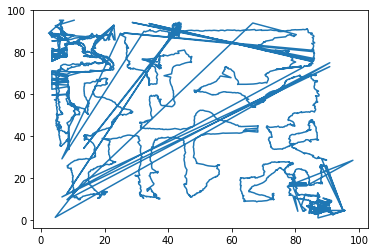

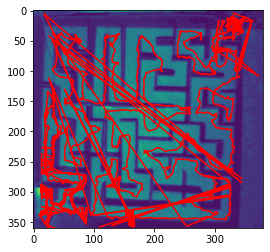

In [18]:
i_day = 4
current_day = i_day
current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
folder =  data[(data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_pc"]
matfile = folder.values[0] + "/" + "behav_new.mat"
videofile = folder.values[0] + "/" + video_name
behav_mat = loadmat(matfile);

### define useful variables: time, positions, etc.
# position number 13
behav_positions = behav_mat['behav'][0][0][14]
behav_time = behav_mat['behav'][0][0][9]
# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))
# delete NAN values
nan_mask = np.isnan(behav_positions).any(axis=1)
end_index = np.where(nan_mask)
behav_time_original = behav_time
behav_positions = behav_positions[~nan_mask, ]
behav_time = behav_time[~nan_mask]
# get start, end time
start_time = behav_time[0]
end_time = behav_time[-1]
total_time = end_time- start_time
stay_time = np.append(np.ediff1d(behav_time),0)
# get end index
end_index = np.where(behav_time_original == end_time)[0][0]
behav_time_original = behav_time_original[0:(end_index+1)]
# define behavior x, y, roi
behav_x = behav_positions[:,0]
behav_y = behav_positions[:,1]
behav_roi = behav_mat['behav'][0][0][12][0]
track_length = behav_mat['behav'][0][0][-1][0]
plt.figure()
plt.plot(behav_positions[:,0], behav_positions[:,1])
roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )


#### perspective transformation
plt.figure()
# get mean frame
mean_frame = get_meanframe(videofile)
# plot mean frame
ori_positions = behav_positions * behav_roi[2]/track_length
plt.plot(ori_positions[:,0],ori_positions[:,1], color = "red")
plt.imshow(mean_frame[roi[2]:roi[3], roi[0]:roi[1]].astype(int))
equ_meanframe = cv2.equalizeHist(np.uint8(mean_frame[roi[2]:roi[3], roi[0]:roi[1]]))
ori_positions = behav_positions * behav_roi[2]/track_length
FINAL_LINE_COLOR = (255, 100, 0)
WORKING_LINE_COLOR = (127, 127, 127)
polydraw = PolygonDrawer("Original: select 4 maze corners", equ_meanframe, ori_positions)
warped_image,warped_positions, M  = polydraw.run()
cv2.imwrite("img/"+current_sign+"_polygon.png", warped_image)
print("Polygon = %s" % polydraw.points)
with open('data/' + current_sign + "PerspTrans.pkl", 'wb') as f:
    pickle.dump(M, f)
cv2.destroyWindow("Original: select 4 maze corners")
cv2.destroyWindow("Processed Maze")
# plot results
maxWidth = 360
maxHeight = 360
neg_mask = (warped_positions<0).any(axis =1)
processed_pos = warped_positions
processed_pos[warped_positions <0] = 0
processed_pos[warped_positions[:,0] >maxWidth, 0] = maxWidth
processed_pos[warped_positions[:,1] >maxHeight, 1] = maxHeight
plt.figure()
plt.imshow(warped_image)
plt.plot(processed_pos[:,0], processed_pos[:,1], color = "red")
plt.savefig('img/'+current_sign+'warped_image.png', dpi=100)

#### calculate occupation time in each bin
_nbins = 12
_coords_range = [[0,maxWidth +0.01],[0, maxHeight+0.01]]
activation = stay_time
occu_time, xbin_edges, ybin_edges, bin_numbers = calculate_ratemap(processed_pos, activation, statistic = "sum", _nbins = _nbins, _coords_range=_coords_range)
# plot
plt.figure()
cm="hot"
plot_ratemap(np.transpose(occu_time), cmap=cm, alpha = 0.8)
plt.savefig('img/'+current_sign+'occutime_bin.png', dpi=100)


#### Incorporate maze structure to behavior trajectory: interpolation, etc..
# transform bin number, making upper right bin (1, 1)
transformed_bin_number = transform_bin(bin_numbers)
nx = 12
ny = 12
graph =maze1_graph if maze_type==1 else maze2_graph
total_bin = nx*ny
start_node = 1
end_node = 144
test_maze = Maze(nx, ny, graph)
new_maze = test_maze.make_maze()
shortest_path = BFS_SP(graph, start_node, end_node)
behav_nodes = test_maze.loc_to_idx(transformed_bin_number[0,:]-1, transformed_bin_number[1,:]-1)
## interpolation
behav_nodes_interpolated = interpolate_pos_maze(behav_time, behav_nodes, behav_time_original, graph, test_maze)
## behave direction
behav_dir = get_direction(behav_nodes_interpolated, test_maze, shortest_path)

## calculate stay time on correct and incorrect path
stay_time_original = np.append(np.ediff1d(behav_time_original),0)
# calculate time spent in each node
correct_time = 0
wrong_time = 0
for i in range(len(stay_time_original)):
    if (behav_nodes_interpolated[i] in shortest_path) & (behav_dir[i] == 1):
        correct_time += stay_time_original[i]
    else:
        wrong_time += stay_time_original[i]
print("Total time: " + str((correct_time+wrong_time)/1000) + " s, \n Time on correct path & direction: " + str(correct_time/1000) + " s (" + "{:.2f}".format(correct_time/total_time*100) + "%), \n Time on incorrect path or direction : "+ str(wrong_time/1000) + " s (" + "{:.2f}".format(wrong_time/total_time*100) + "%)")

## correct decision rate: current frame at decision point, next frame at next cell in among the shortest path
# total_decision = np.zeros(len(test_maze.decision_nodes))
correct_decision = np.zeros(len(test_maze.decision_nodes))
incorrect_decision = np.zeros(len(test_maze.decision_nodes))
for i in range(len(behav_nodes_interpolated)-1):
    # check current node is a decision node, and not the same as next node (decision is made)
    if (behav_nodes_interpolated[i] in test_maze.decision_nodes) & (behav_nodes_interpolated[i+1] != behav_nodes_interpolated[i]):
        current_idx_path = test_maze.shortest_path.index(behav_nodes_interpolated[i])
        current_idx_decision = test_maze.decision_nodes.index(behav_nodes_interpolated[i])
        right_next_node = test_maze.shortest_path[current_idx_path+1]
        # go to next node on shortest path
        if behav_nodes_interpolated[i+1] == right_next_node:
            correct_decision[current_idx_decision] += 1
        elif behav_nodes_interpolated[i+1] in graph.get(behav_nodes_interpolated[i]):
            incorrect_decision[current_idx_decision] += 1
total_decision = correct_decision + incorrect_decision
# overall correct rate
decision_rate = sum(correct_decision)/sum(total_decision)
print("Overall Correct Rate: " + "{:.2f}".format(decision_rate*100)+ "%")

##  time spent in each level
total_levels = len(test_maze.decision_nodes)
time_levels = np.zeros(total_levels)
for i in range(len(stay_time_original)):
    level_ind = test_maze.cell_levels[behav_nodes_interpolated[i]-1]
    time_levels[level_ind] += stay_time_original[i]
first_half_time = np.sum(time_levels[:(len(time_levels)//2)])
total_time = np.sum(time_levels)
print("% Time spent in first 1/2 levels: " + "{:.2f}".format(first_half_time/total_time*100)+ "%")


#### Save files
# decision related data
with open('data/' + current_sign +'behav_decision.pkl', 'wb') as f:
    pickle.dump([correct_time/1000, wrong_time/1000, correct_time/(correct_time+wrong_time), decision_rate, time_levels], f)
# behav time, nodes, direction data
mylist = [behav_time_original, behav_nodes_interpolated, behav_dir]
with open('data/' + current_sign +'behav_processed.pkl', 'wb') as f:
    pickle.dump(mylist, f)


In [16]:
occu_time[11,0] = 100

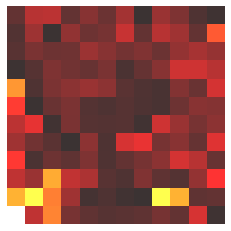

In [17]:
plot_ratemap(np.transpose(occu_time), cmap=cm, alpha = 0.8)


13728.0

In [8]:
behav_mat['behav'][0][0][14]

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

In [16]:
graph =maze1_graph if maze_type==1 else maze2_graph


In [6]:
behav_positions.shape

(290, 347, 3)

In [8]:
behav_mat['behav'][0][0][15]

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])

In [4]:
maze_type

1

M10031maze1Day6
Adding point #0 with position(112,128)
Polygon = [(112, 128)]
The maze is bidirectional, Ye!
Total time: 269.552 s, 
 Time on correct path & direction: 269.552 s (100.17%), 
 Time on incorrect path or direction : 0.0 s (0.00%)
Overall Correct Rate: nan%
% Time spent in first 1/2 levels: 100.00%


<ipython-input-2-fab6fc682067>:136: RuntimeWarning: invalid value encountered in double_scalars
  decision_rate = sum(correct_decision)/sum(total_decision)


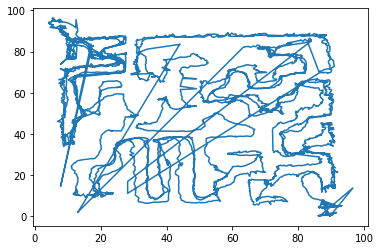

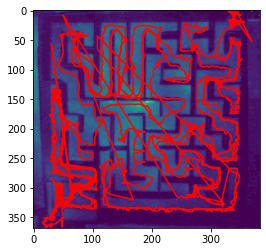

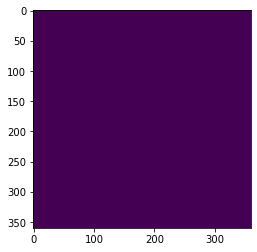

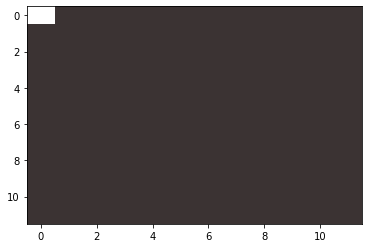

In [2]:
maze_type = 1
i_day = 6
current_day = i_day
current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
print(current_sign)
folder =  data[(data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_local"]
matfile = folder.values[0] + "/" + "behav_new.mat"
videofile = folder.values[0] + "/" + video_name
behav_mat = loadmat(matfile);

### define useful variables: time, positions, etc.
# position number 13
behav_positions = behav_mat['behav'][0][0][14]
behav_time = behav_mat['behav'][0][0][9]
# delete first 50 frames (~1.7s), when the mouse is not in the maze
delete_start = 50
behav_positions = np.delete(behav_positions, range(0,delete_start),0)
behav_time = np.delete(behav_time, range(0,delete_start))
# delete NAN values
nan_mask = np.isnan(behav_positions).any(axis=1)
end_index = np.where(nan_mask)
behav_time_original = behav_time
behav_positions = behav_positions[~nan_mask, ]
behav_time = behav_time[~nan_mask]
# get start, end time
start_time = behav_time[0]
end_time = behav_time[-1]
total_time = end_time- start_time
stay_time = np.append(np.ediff1d(behav_time),0)
# get end index
end_index = np.where(behav_time_original == end_time)[0][0]
behav_time_original = behav_time_original[0:(end_index+1)]
# define behavior x, y, roi
behav_x = behav_positions[:,0]
behav_y = behav_positions[:,1]
behav_roi = behav_mat['behav'][0][0][12][0]
track_length = behav_mat['behav'][0][0][-1][0]
plt.figure()
plt.plot(behav_positions[:,0], behav_positions[:,1])
roi = np.int32([behav_roi[0], behav_roi[0]+behav_roi[2], behav_roi[1], behav_roi[1]+behav_roi[3]] )


#### perspective transformation
plt.figure()
# get mean frame
mean_frame = get_meanframe(videofile)
# plot mean frame
ori_positions = behav_positions * behav_roi[2]/track_length
plt.plot(ori_positions[:,0],ori_positions[:,1], color = "red")
plt.imshow(mean_frame[roi[2]:roi[3], roi[0]:roi[1]].astype(int))
equ_meanframe = cv2.equalizeHist(np.uint8(mean_frame[roi[2]:roi[3], roi[0]:roi[1]]))
ori_positions = behav_positions * behav_roi[2]/track_length
FINAL_LINE_COLOR = (255, 100, 0)
WORKING_LINE_COLOR = (127, 127, 127)
polydraw = PolygonDrawer("Original: select 4 maze corners", equ_meanframe, ori_positions)
warped_image,warped_positions, M  = polydraw.run()
cv2.imwrite("img/"+current_sign+"_polygon.png", warped_image)
print("Polygon = %s" % polydraw.points)
with open('data/' + current_sign + "PerspTrans.pkl", 'wb') as f:
    pickle.dump(M, f)
cv2.destroyWindow("Original: select 4 maze corners")
cv2.destroyWindow("Processed Maze")
# plot results
maxWidth = 360
maxHeight = 360
neg_mask = (warped_positions<0).any(axis =1)
processed_pos = warped_positions
processed_pos[warped_positions <0] = 0
processed_pos[warped_positions[:,0] >maxWidth, 0] = maxWidth
processed_pos[warped_positions[:,1] >maxHeight, 1] = maxHeight
plt.figure()
plt.imshow(warped_image)
plt.plot(processed_pos[:,0], processed_pos[:,1], color = "red")
plt.savefig('img/'+current_sign+'warped_image.png', dpi=100)

#### calculate occupation time in each bin
_nbins = 12
_coords_range = [[0,maxWidth +0.01],[0, maxHeight+0.01]]
activation = stay_time
occu_time, xbin_edges, ybin_edges, bin_numbers = calculate_ratemap(processed_pos, activation, statistic = "sum", _nbins = _nbins, _coords_range=_coords_range)
# plot
plt.figure()
cm="hot"
plot_ratemap(np.transpose(occu_time), cmap=cm, alpha = 0.8)
plt.savefig('img/'+current_sign+'occutime_bin.png', dpi=100)


#### Incorporate maze structure to behavior trajectory: interpolation, etc..
# transform bin number, making upper right bin (1, 1)
transformed_bin_number = transform_bin(bin_numbers)
nx = 12
ny = 12

graph = maze1_graph if maze_type==1 else maze2_graph
total_bin = nx*ny
start_node = 1
end_node = 144
test_maze = Maze(nx, ny, graph)
new_maze = test_maze.make_maze()
shortest_path = BFS_SP(graph, start_node, end_node)
behav_nodes = test_maze.loc_to_idx(transformed_bin_number[0,:]-1, transformed_bin_number[1,:]-1)
## interpolation
behav_nodes_interpolated = interpolate_pos_maze(behav_time, behav_nodes, behav_time_original, graph, test_maze)
## behave direction
behav_dir = get_direction(behav_nodes_interpolated, test_maze, shortest_path)

## calculate stay time on correct and incorrect path
stay_time_original = np.append(np.ediff1d(behav_time_original),0)
# calculate time spent in each node
correct_time = 0
wrong_time = 0
for i in range(len(stay_time_original)):
    if (behav_nodes_interpolated[i] in shortest_path) & (behav_dir[i] == 1):
        correct_time += stay_time_original[i]
    else:
        wrong_time += stay_time_original[i]
print("Total time: " + str((correct_time+wrong_time)/1000) + " s, \n Time on correct path & direction: " + str(correct_time/1000) + " s (" + "{:.2f}".format(correct_time/total_time*100) + "%), \n Time on incorrect path or direction : "+ str(wrong_time/1000) + " s (" + "{:.2f}".format(wrong_time/total_time*100) + "%)")

## correct decision rate: current frame at decision point, next frame at next cell in among the shortest path
# total_decision = np.zeros(len(test_maze.decision_nodes))
correct_decision = np.zeros(len(test_maze.decision_nodes))
incorrect_decision = np.zeros(len(test_maze.decision_nodes))
for i in range(len(behav_nodes_interpolated)-1):
    # check current node is a decision node, and not the same as next node (decision is made)
    if (behav_nodes_interpolated[i] in test_maze.decision_nodes) & (behav_nodes_interpolated[i+1] != behav_nodes_interpolated[i]):
        current_idx_path = test_maze.shortest_path.index(behav_nodes_interpolated[i])
        current_idx_decision = test_maze.decision_nodes.index(behav_nodes_interpolated[i])
        right_next_node = test_maze.shortest_path[current_idx_path+1]
        # go to next node on shortest path
        if behav_nodes_interpolated[i+1] == right_next_node:
            correct_decision[current_idx_decision] += 1
        elif behav_nodes_interpolated[i+1] in graph.get(behav_nodes_interpolated[i]):
            incorrect_decision[current_idx_decision] += 1
total_decision = correct_decision + incorrect_decision
# overall correct rate
decision_rate = sum(correct_decision)/sum(total_decision)
print("Overall Correct Rate: " + "{:.2f}".format(decision_rate*100)+ "%")

##  time spent in each level
total_levels = len(test_maze.decision_nodes)
time_levels = np.zeros(total_levels)
for i in range(len(stay_time_original)):
    level_ind = test_maze.cell_levels[behav_nodes_interpolated[i]-1]
    time_levels[level_ind] += stay_time_original[i]
first_half_time = np.sum(time_levels[:(len(time_levels)//2)])
total_time = np.sum(time_levels)
print("% Time spent in first 1/2 levels: " + "{:.2f}".format(first_half_time/total_time*100)+ "%")


#### Save files
# decision related data
with open('data/' + current_sign +'behav_decision.pkl', 'wb') as f:
    pickle.dump([correct_time/1000, wrong_time/1000, correct_time/(correct_time+wrong_time), decision_rate, time_levels], f)
# behav time, nodes, direction data
mylist = [behav_time_original, behav_nodes_interpolated, behav_dir]
with open('data/' + current_sign +'behav_processed.pkl', 'wb') as f:
    pickle.dump(mylist, f)

del test_maze

In [4]:
folder

Series([], Name: recording_folder_local, dtype: object)

In [10]:
Maze(nx, ny, graph)


The maze is bidirectional, Ye!


ValueError: 14 is not in list

In [11]:
graph

{1: [2],
 2: [1, 3, 14],
 3: [2, 15],
 4: [16],
 5: [6, 17],
 6: [5, 7],
 7: [6, 8, 19],
 8: [7, 20],
 9: [10, 21],
 10: [9, 11],
 11: [10, 12],
 12: [11, 24],
 13: [14, 25],
 14: [2, 13],
 15: [3, 16],
 16: [4, 15],
 17: [5, 29],
 18: [19, 30],
 19: [7, 18],
 20: [8],
 21: [9, 33],
 22: [23, 34],
 23: [22, 24],
 24: [12, 23, 36],
 25: [13, 37],
 26: [27],
 27: [26, 39],
 28: [29, 40],
 29: [17, 28],
 30: [18, 31],
 31: [30, 43],
 32: [33, 44],
 33: [21, 32],
 34: [22, 46],
 35: [36, 47],
 36: [35, 24],
 37: [25, 49],
 38: [50],
 39: [27, 51],
 40: [28, 52],
 41: [42, 53],
 42: [41],
 43: [31, 44],
 44: [32, 43, 56],
 45: [46, 57],
 46: [34, 45],
 47: [35],
 48: [60],
 49: [37, 61],
 50: [38, 51, 62],
 51: [39, 50, 52],
 52: [51, 40, 53],
 53: [41, 52, 65],
 54: [55, 66],
 55: [54, 67],
 56: [44],
 57: [45, 69],
 58: [70],
 59: [71, 60],
 60: [48, 59, 72],
 61: [49, 73],
 62: [50],
 63: [64, 75],
 64: [63, 65],
 65: [64, 53],
 66: [54, 78],
 67: [55, 68],
 68: [67, 69],
 69: [68, 57],


In [12]:
mice_status["name"][1][0]

IndexError: invalid index to scalar variable.

In [18]:
type(mice_status["name"][0])

numpy.int64

In [42]:
(data.name == mice_names[0])& (data.maze_type == 1)

0       True
1       True
2       True
3       True
4       True
       ...  
147    False
148    False
149    False
150    False
151    False
Length: 152, dtype: bool

In [38]:
data.name == mice_names[0] & data.maze_type == 1

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [39]:
data.name == mice_names[0]

0       True
1       True
2       True
3       True
4       True
       ...  
147    False
148    False
149    False
150    False
151    False
Name: name, Length: 152, dtype: bool

In [49]:
data[(data.training_day == current_day) & (data.maze_type == maze_type)]

,name,training_day,maze_type,recording_folder,recording_folder_pc,note
0,10019,1,1,H:\miniscope recording\maze\4_18_2020\10019H16...,Z:/miniscope_recording/maze/4_18_2020/10019H16...,NaN
16,10021,1,1,H:\miniscope recording\maze\4_17_2020\10021H19...,Z:/miniscope_recording/maze/4_17_2020/10021H19...,NaN
25,10023,1,1,H:\miniscope recording\maze\4_17_2020\10023H20...,Z:/miniscope_recording/maze/4_17_2020/10023H20...,NaN
42,10024,1,1,H:\miniscope recording\maze\4_17_2020\10024H13...,Z:/miniscope_recording/maze/4_17_2020/10024H13...,NaN
59,10026,1,1,H:\miniscope recording\maze\4_17_2020\10026H14...,Z:/miniscope_recording/maze/4_17_2020/10026H14...,NaN
68,10027,1,1,H:\miniscope recording\maze\4_17_2020\10027H15...,Z:/miniscope_recording/maze/4_17_2020/10027H15...,combined from two broken parts
77,10028,1,1,H:\miniscope recording\maze\4_17_2020\10028H16...,Z:/miniscope_recording/maze/4_17_2020/10028H16...,NaN
94,10030,1,1,H:\miniscope recording\maze\4_17_2020\10030H17...,Z:/miniscope_recording/maze/4_17_2020/10030H17...,NaN
111,10032,1,1,H:\miniscope recording\maze\4_17_2020\10032H18...,Z:/miniscope_recording/maze/4_17_2020/10032H18...,NaN
128,10031,1,1,H:\miniscope recording\maze\4_18_2020\10031H13...,Z:/miniscope_recording/maze/4_18_2020/10031H13...,NaN


In [4]:
current_sign

'M10019maze1Day2'

In [4]:
current_sign

'M10019maze2Day1'

In [4]:
maze_type

2

In [5]:
folder

8      Z:/miniscope_recording/maze/4_28_2020/10019H15...
34     Z:/miniscope_recording/maze/4_28_2020/10023H12...
51     Z:/miniscope_recording/maze/4_28_2020/10024H18...
86     Z:/miniscope_recording/maze/4_28_2020/10028H17...
103    Z:/miniscope_recording/maze/4_28_2020/10030H16...
120    Z:/miniscope_recording/maze/4_28_2020/10032H11...
136    Z:/miniscope_recording/maze/4_28_2020/10031H14...
Name: recording_folder_local, dtype: object

In [6]:
data[(data.training_day == current_day) & (data.maze_type == maze_type)]

,name,training_day,maze_type,recording_folder,recording_folder_local,note
8,10019,1,2,H:\miniscope recording\maze\4_28_2020\10019H15...,Z:/miniscope_recording/maze/4_28_2020/10019H15...,NaN
34,10023,1,2,H:\miniscope recording\maze\4_28_2020\10023H12...,Z:/miniscope_recording/maze/4_28_2020/10023H12...,NaN
51,10024,1,2,H:\miniscope recording\maze\4_28_2020\10024H18...,Z:/miniscope_recording/maze/4_28_2020/10024H18...,NaN
86,10028,1,2,H:\miniscope recording\maze\4_28_2020\10028H17...,Z:/miniscope_recording/maze/4_28_2020/10028H17...,NaN
103,10030,1,2,H:\miniscope recording\maze\4_28_2020\10030H16...,Z:/miniscope_recording/maze/4_28_2020/10030H16...,NaN
120,10032,1,2,H:\miniscope recording\maze\4_28_2020\10032H11...,Z:/miniscope_recording/maze/4_28_2020/10032H11...,NaN
136,10031,1,2,H:\miniscope recording\maze\4_28_2020\10031H14...,Z:/miniscope_recording/maze/4_28_2020/10031H14...,NaN


In [5]:
training_day_set

{1}

In [8]:
behav_time.shape

(3975,)

In [10]:
behav_positions.shape

(295, 361, 3)

In [5]:
len(behav_mat['behav'][0][0])

20

In [37]:
mice_names = mice_status["name"]
mice_names = mice_names.drop(4)
# maze_type_mice = set(data[data.name == mice_names[0]]["maze_type"])
maze_type_set = set(data[data.name == mice_name]["maze_type"])
training_day_set = set(data[(data.name == mice_names[0]) & (data.maze_type == 1)]["training_day"])
for mice_name in mice_names:
    maze_type_set = set(data[data.name == mice_name]["maze_type"])

    for maze_type in maze_type_set:
        # training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])
        training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])
        for i_day in training_day_set:
            current_day = i_day
            current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
            if( current_sign != "M10033maze1Day3"):
                folder =  data[(data.name == mice_name) & (data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_local"]
                matfile = folder.values[0] + "/" + "behav_new.mat"
                videofile = folder.values[0] + "/" + video_name
                behav_mat = loadmat(matfile);
                if(len(behav_mat['behav'][0][0]) != 19):
                    print(current_sign)
                    print(folder)
                    print("behav length:", len(behav_mat['behav'][0][0]))


M10023maze1Day7
31    Z:/miniscope_recording/maze/4_23_2020/10023H11...
Name: recording_folder_local, dtype: object
behav length: 20


In [27]:
mice_names

0     10019
1     10021
2     10023
3     10024
4     10026
5     10027
6     10028
7     10030
8     10031
9     10032
10    10033
Name: name, dtype: int64

In [25]:
mice_names.drop(4)

0     10019
1     10021
2     10023
3     10024
5     10027
6     10028
7     10030
8     10031
9     10032
10    10033
Name: name, dtype: int64

In [35]:
import h5py
mice_names = mice_status["name"]
mice_names = mice_names.drop(4)
# maze_type_mice = set(data[data.name == mice_names[0]]["maze_type"])
maze_type_set = set(data[data.name == mice_name]["maze_type"])
training_day_set = set(data[(data.name == mice_names[0]) & (data.maze_type == 1)]["training_day"])
for mice_name in mice_names:
    maze_type_set = set(data[data.name == mice_name]["maze_type"])

    for maze_type in maze_type_set:
        # training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])
        training_day_set = set(data[(data.name == mice_name) & (data.maze_type == maze_type)]["training_day"])
        for i_day in training_day_set:
            current_day = i_day
            current_sign = "M" + str(mice_name)+"maze"+str(maze_type)+"Day"+str(current_day)
            if( current_sign != "M10033maze1Day3"):
                folder =  data[(data.name == mice_name) & (data.training_day == current_day) & (data.maze_type == maze_type)]["recording_folder_local"]
                matfile = folder.values[0] + "/" + "ms.mat"
                videofile = folder.values[0] + "/" + video_name
                with h5py.File(matfile, 'r') as f:
                    ms_mat = f['ms']
                    if(len(ms_mat)!=28):
                        print(current_sign)
                        print(folder)
                        print("ms data length:",len(ms_mat))


M10019maze2Day3
10    Z:/miniscope_recording/maze/4_30_2020/10019H14...
Name: recording_folder_local, dtype: object
ms data length: 26
M10024maze1Day8
49    Z:/miniscope_recording/maze/4_24_2020/10024H17...
Name: recording_folder_local, dtype: object
ms data length: 27
M10027maze1Day1
68    Z:/miniscope_recording/maze/4_17_2020/10027H15...
Name: recording_folder_local, dtype: object
ms data length: 26
M10031maze1Day3
130    Z:/miniscope_recording/maze/4_20_2020/10031H16...
Name: recording_folder_local, dtype: object
ms data length: 25
M10031maze1Day7
134    Z:/miniscope_recording/maze/4_24_2020/10031H15...
Name: recording_folder_local, dtype: object
ms data length: 27


In [4]:
import 
with h5py.File(matfile, 'r') as f:
    ms_mat = f['ms']


NameError: name 'h5py' is not defined

In [5]:
            matfile = folder.values[0] + "/" + "behav_new.mat"
            videofile = folder.values[0] + "/" + video_name
            behav_mat = loadmat(matfile);

            ### define useful variables: time, positions, etc.
            # position number 13
            behav_positions = behav_mat['behav'][0][0][14]
            behav_time = behav_mat['behav'][0][0][9]


In [6]:
behav_positions.shape

(111456, 2)

In [7]:
behav_time.shape

(126669, 1)